In [26]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import sys, os
sys.path.append('../')

import numpy as np, pandas as pd, scipy, h5py
import astropy
from astropy import units as u
import astromet
from astromet.track import design_matrix
#import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import scanninglaw.times
from scanninglaw.source import Source

In [28]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [29]:
data = {}
with h5py.File('/data/vault/asfe2/Conferences/EDR3_workshop/gums_sample.h', 'r') as hf:
    for key in hf.keys():
        data[key] = hf[key][...]

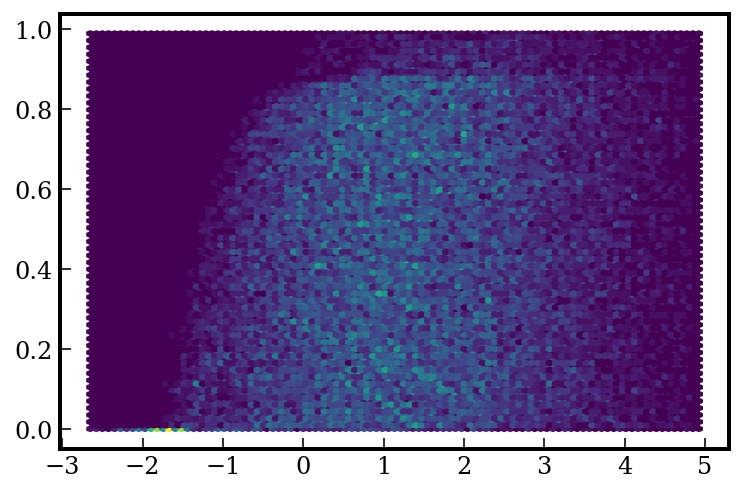

In [10]:
plt.hexbin(np.log10(data['semimajor_axis']),data['eccentricity'])

In [23]:
print(f"Binaries: {np.sum(data['binary'])}")
print(f"Unresolved: {np.sum((1+data['eccentricity'])*data['semimajor_axis']/data['barycentric_distance']<0.18)}")

Binaries: 32708
Unresolved: 13030


In [11]:
data.keys()

dict_keys(['age', 'alphafe', 'barycentric_distance', 'binary', 'dec', 'eccentricity', 'feh', 'inclination', 'longitude_ascending_node', 'orbit_period', 'periastron_argument', 'periastron_date', 'pmdec', 'pmra', 'population', 'primary_logg', 'primary_mag_bp', 'primary_mag_g', 'primary_mag_rp', 'primary_mag_rvs', 'primary_mass', 'primary_radius', 'primary_teff', 'primary_variability_amplitude', 'primary_variability_period', 'primary_variability_phase', 'primary_variability_type', 'primary_vsini', 'ra', 'radial_velocity', 'secondary_logg', 'secondary_mag_bp', 'secondary_mag_g', 'secondary_mag_rp', 'secondary_mag_rvs', 'secondary_mass', 'secondary_radius', 'secondary_teff', 'secondary_variability_amplitude', 'secondary_variability_period', 'secondary_variability_phase', 'secondary_variability_type', 'secondary_vsini', 'semimajor_axis', 'system_id'])

In [12]:
data['system_id']

array([b'*134219253-000005', b'*134222721-000003', b'*134222763-000066',
       ..., b'*268427330-000001', b'*268430022-000001',
       b'*268434035-000002'], dtype='|S17')

In [13]:
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt
import tqdm, h5py


# Download from Gaia archive
job = Gaia.launch_job_async("select * from gaiaedr3.gaia_universe_model where barycentric_distance < 100")
gums = job.get_results()
gums.sort('source_extended_id')
gums['system_id'] = np.array(gums['source_extended_id'], dtype='S17')
gums.add_index('source_extended_id')

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]


In [14]:
# Get multiplicity of sources
systems = np.array([sei[:17] for sei in gums['source_extended_id'] if '+' not in sei])
multiplicity = {sys_id:multiplicity for sys_id,multiplicity  in zip(*np.unique(systems, return_counts=True))}

In [21]:
hierarchy = np.array([sei[17:] for sei in gums['source_extended_id']])

In [22]:
np.unique(hierarchy)

array(['      ', '+     ', '+V    ', 'A     ', 'AV    ', 'B     ',
       'BV    ', 'C     ', 'CV    ', 'D     ', 'DV    ', 'E     ',
       'EV    ', 'V     '], dtype='<U6')

In [30]:
data = {}
with h5py.File('/data/vault/asfe2/Conferences/EDR3_workshop/gums_sample_reparameterised.h', 'r') as hf:
    for key in hf.keys():
        data[key] = hf[key][...]

In [35]:
data['system_id'][0]+b'A'

b'*134219253-000005A'

In [ ]:




# Get binaries
binaries = {'system_id':[]}
star_keys = ['mass','mag_g','mag_bp','mag_rp','mag_rvs','teff','logg','radius','vsini','variability_type','variability_amplitude','variability_period','variability_phase']
system_keys = ['ra','dec','barycentric_distance','pmra','pmdec','radial_velocity','population','age','feh','alphafe']
orbit_keys = ['semimajor_axis','eccentricity','inclination','longitude_ascending_node','orbit_period','periastron_date','periastron_argument']

for key in star_keys:
  binaries['primary_'+key] = []
  binaries['secondary_'+key] = []
for key in system_keys+orbit_keys:
  binaries[key] = []

for i in tqdm.tqdm(range(len(gums))):
  if multiplicity[gums['system_id'][i]] == 2 and gums['source_extended_id'][i]==gums['system_id'][i]+'+     ':

    node = gums[i]
    primary = gums[i+1]
    secondary = gums[i+2]

    assert (primary['source_extended_id'] == gums['system_id'][i]+'A     ') | (primary['source_extended_id'] == gums['system_id'][i]+'AV    ')
    assert (secondary['source_extended_id'] == gums['system_id'][i]+'B     ') | (secondary['source_extended_id'] == gums['system_id'][i]+'BV    ')

    binaries['system_id'].append(node['system_id'])

    for key in star_keys:
      binaries['primary_'+key].append(primary[key])
      binaries['secondary_'+key].append(secondary[key])

    for key in system_keys:
      binaries[key].append(node[key])

    for key in orbit_keys:
      binaries[key].append(secondary[key])


# Get single sources
sys_id, multiplicity = np.unique(systems, return_counts=True)
single_source = np.intersect1d(np.array(gums['source_extended_id'], dtype='S17'),
                               sys_id[multiplicity==1], return_indices=True)[1]

star_keys = ['mass','mag_g','mag_bp','mag_rp','mag_rvs','teff','logg','radius','vsini','variability_type','variability_amplitude','variability_period','variability_phase','spectral_type']
system_keys = ['ra','dec','barycentric_distance','pmra','pmdec','radial_velocity','population','age','feh','alphafe']
orbit_keys = ['semimajor_axis','eccentricity','inclination','longitude_ascending_node','orbit_period','periastron_date','periastron_argument']
singles = {'system_id':np.array(gums['source_extended_id'], dtype='S17')[single_source]}

for key in star_keys:
  singles['primary_'+key] = gums[key][single_source]
  singles['secondary_'+key] = np.zeros(len(single_source))+np.nan

for key in system_keys:
  singles[key] = gums[key][single_source]

for key in orbit_keys:
  singles[key] = np.zeros(len(single_source))+np.nan

# Convert types
dtypes = {'system_id':'S17',
          'primary_variability_type':'S32',
          'secondary_variability_type':'S32'}
data = {}
for key in singles.keys():
    data[key] = np.hstack((singles[key], binaries[key]))
for key in dtypes:
    data[key] = data[key].astype(dtypes[key])
data['binary'] = np.hstack((np.zeros(len(singles['system_id']), dtype=bool),
                            np.ones(len(binaries['system_id']), dtype=bool)))

# Save
with h5py.File('/data/vault/asfe2/Conferences/EDR3_workshop/gums_sample.h', 'w') as hf:
    for key in data.keys():
        print(key)
        hf.create_dataset(key, data=data[key])
